In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers, models, optimizers, utils, regularizers
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
assert(tf.test.gpu_device_name())

2022-03-30 15:52:11.286894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-30 15:52:11.356114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:11.404635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:11.404853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
'''
    Cria uma função (int_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

int_func=lambda x: int(x)
vint_func=np.vectorize(int_func)

In [4]:
'''
    Cria uma função (ord_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

ord_func=lambda x: ord(x)-65 ## ATENÇÃO: veja abaixo o motivo de ter subtraído 65
vord_func=np.vectorize(ord_func)

#### Um breve interregno

Aqui faz-se necessário explicar de forma mais detalhada o motivo de subtrair 65 na função acima. De acordo com a documentação, ord(c) recebe uma string representando um único caractere Unicode e retorna um inteiro representando o código Unicode daquele caractere. 'A' tem o código 65, 'B' é 66, ... e 'Z' é 90. Assim, caso fizesse ord_func sem subtrair 65, teríamos

In [5]:
temp_func=lambda x: ord(x) 
vtemp_func=np.vectorize(temp_func)

In [6]:
temp=np.load('training_label_char.npy')
np.unique(temp)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype='<U1')

Dados os códigos Unicode para as letras, ao converter o array acima teríamos

In [7]:
ar=vtemp_func(temp)
np.unique(ar)

array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90])

Ocorre que, ao passar esse array pela função keras.util.to_categorical, esta irá criar o one-hot com 91 posições. O shape será

In [8]:
utils.to_categorical(ar).shape

(5400, 91)

Dessa forma, subtraindo 65 da função ord(c), conseguimos ter um array com shape (5400,26)

Fim do interregno

In [9]:
def load_img_array(file):
    '''
    Lê os arquivos com os arrays das imagens. Divide por 255 para normalizar, pois as imagens eram grayscale. Expande o shape do array, 
    pois o keras precisa ler as entradas com 4 dimensões (batch_shape, rows, cols, channels). 
    '''
    temp=np.load(file)
    temp=temp.astype('float32')/255
    temp=np.expand_dims(temp,axis=-1)
    
    return temp

In [10]:
training_img_char=load_img_array('training_img_char.npy')
training_img_digit=load_img_array('training_img_digit.npy')
testing_img_char=load_img_array('testing_img_char.npy')
testing_img_digit=load_img_array('testing_img_digit.npy')
validation_img_char=load_img_array('validation_img_char.npy')
validation_img_digit=load_img_array('validation_img_digit.npy')

In [11]:
'''
    Lê os arquivos com os arrays dos labels. Notar que tais arrays contêm strings. Será necessário convertê-los para int usando
    a função ord(), quando o label for caractere, e int(), quando for inteiro. Cria o one-hot encode 
'''

training_label_char=utils.to_categorical(vord_func(np.load('training_label_char.npy')))
training_label_digit=utils.to_categorical(vint_func(np.load('training_label_digit.npy')))
testing_label_char=utils.to_categorical(vord_func(np.load('testing_label_char.npy')))
testing_label_digit=utils.to_categorical(vint_func(np.load('testing_label_digit.npy')))
validation_label_char=utils.to_categorical(vord_func(np.load('validation_label_char.npy')))
validation_label_digit=utils.to_categorical(vint_func(np.load('validation_label_digit.npy')))

##### Primeiro modelo para os dígitos

In [12]:
modelo1 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(10,
                activation='softmax')
])

2022-03-30 15:52:30.494642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:30.494935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:30.495373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:30.495885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 15:52:30.496078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [13]:
modelo1.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
hist_modelo1=modelo1.fit(training_img_digit, training_label_digit, 
                 epochs=30,
                 batch_size=512,
                 validation_data=(validation_img_digit, validation_label_digit))

Epoch 1/30


2022-03-30 15:52:34.060529: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-30 15:52:34.403631: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


15/15 [==============================] - 2s 26ms/step - loss: 2.2753 - accuracy: 0.1454 - val_loss: 2.3079 - val_accuracy: 0.1197
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 2.1190 - accuracy: 0.2611 - val_loss: 2.0863 - val_accuracy: 0.1553
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8332 - accuracy: 0.3851 - val_loss: 1.7782 - val_accuracy: 0.3331
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.5436 - accuracy: 0.5443 - val_loss: 1.4901 - val_accuracy: 0.5744
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 1.1707 - accuracy: 0.6899 - val_loss: 1.1580 - val_accuracy: 0.6869
Epoch 6/30
15/15 [==============================] - 0s 10ms/step - loss: 0.7807 - accuracy: 0.7785 - val_loss: 0.9923 - val_accuracy: 0.7122
Epoch 7/30
15/15 [==============================] - 0s 10ms/step - loss: 0.5269 - accuracy: 0.8589 - val_loss: 0.7451 - val_accuracy: 0.7558
Epoch 8/30
15/15 [======

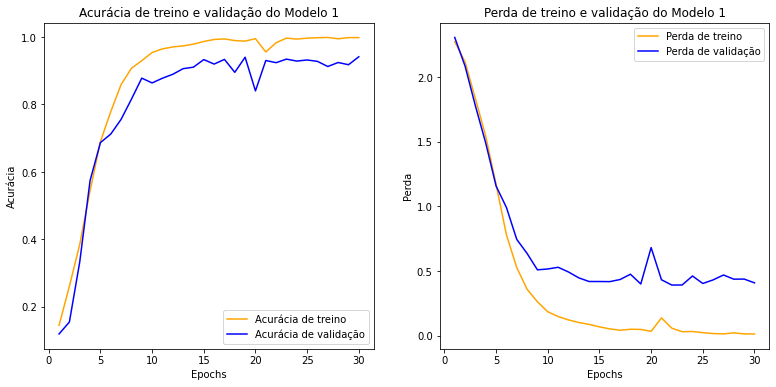

In [15]:
def plotar_acuracia_loss(modelo,nome):
    
    epochs=range(1,len(modelo.history['accuracy'])+1)

    plt.rcParams["figure.figsize"] = (13,6)

    plt.subplot(1, 2, 1)

    plt.plot(epochs,modelo.history['accuracy'], color='orange', label='Acurácia de treino')
    plt.plot(epochs,modelo.history['val_accuracy'], 'b', label ='Acurácia de validação')
    plt.title('Acurácia de treino e validação do '+nome)
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs,modelo.history['loss'], color='orange', label='Perda de treino')
    plt.plot(epochs,modelo.history['val_loss'], 'b', label ='Perda de validação')
    plt.title('Perda de treino e validação do '+nome)
    plt.xlabel('Epochs')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()
    
plotar_acuracia_loss(hist_modelo1,"Modelo 1")

##### Segundo modelo para as letras

In [24]:
modelo2 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(26,
                activation='softmax')
])

In [25]:
modelo2.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
hist_modelo2=modelo2.fit(training_img_char, training_label_char, 
                 epochs=30,
                 batch_size=512,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/30
11/11 [==============================] - 1s 25ms/step - loss: 3.1072 - accuracy: 0.2315 - val_loss: 3.0310 - val_accuracy: 0.2889
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 2.8916 - accuracy: 0.2722 - val_loss: 2.8849 - val_accuracy: 0.2889
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 2.8204 - accuracy: 0.2722 - val_loss: 2.8516 - val_accuracy: 0.2889
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 2.7571 - accuracy: 0.2722 - val_loss: 2.7909 - val_accuracy: 0.2889
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 2.6409 - accuracy: 0.3019 - val_loss: 2.6827 - val_accuracy: 0.3396
Epoch 6/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4479 - accuracy: 0.3359 - val_loss: 2.5145 - val_accuracy: 0.3567
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 2.1779 - accuracy: 0.3767 - val_loss: 2.3142 - val_accuracy: 0.3926
Epoch 8/30
11

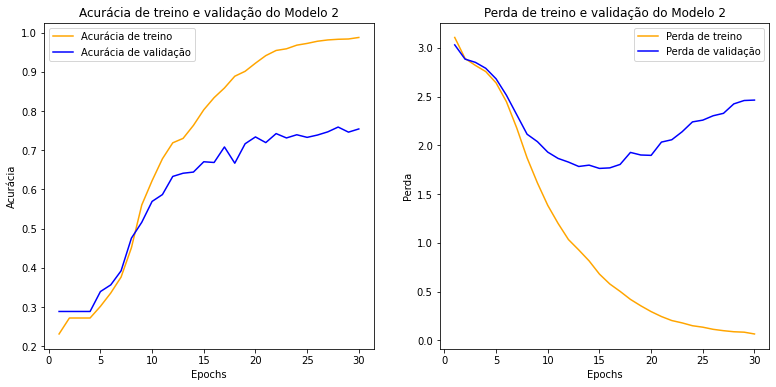

In [27]:
plotar_acuracia_loss(hist_modelo2,"Modelo 2")